In [ ]:
import imageio
import numpy as np
import spatialdata_plot
import matplotlib.pyplot as plt

# helper to grab centre frac of a 2D mask
def central_crop(mask: np.ndarray, frac: float = 1) -> np.ndarray:
    H, W = mask.shape
    ch, cw = int(H * frac), int(W * frac)
    sh, sw = (H - ch)//2, (W - cw)//2
    return mask[sh:sh+ch, sw:sw+cw]


def calculate_dice_based_reference(sdata, shape, frac = 1):
    plotter_boundaries = (
        sdata
        .pl.render_shapes(shape,           color="red",  fill_alpha=0)
        .pl.render_shapes("cell_boundaries", color="blue", fill_alpha=1)
    )
    out1 = f"/tmp/{shape}_boundaries.png"
    plotter_boundaries.pl.show(coordinate_systems="global",
                               dpi=100,
                               save=out1)

    # 2) Build & save the “Cellpose masks” image:
    #    (fill this shape in red, outline the manual boundaries in blue)
    plotter_cellpose = (
        sdata
        .pl.render_shapes(shape,           color="red",  fill_alpha=1)
        .pl.render_shapes("cell_boundaries", color="blue", fill_alpha=0)
    )
    out2 = f"/tmp/{shape}_cellpose.png"
    plotter_cellpose.pl.show(coordinate_systems="global",
                             dpi=100,
                             save=out2)

    # 3) Read back and extract boolean masks
    img_bound = imageio.v2.imread(out1)
    img_cp    = imageio.v2.imread(out2)

    mask_bound = img_bound[..., 0] != 0   # red channel → boolean
    mask_cp    = img_cp[...,    2] != 0   # blue channel → boolean

    
    mask_bound_c  = central_crop(mask_bound, frac=frac)
    mask_cp_c     = central_crop(mask_cp,    frac=frac)
    intersection_c = np.logical_and(mask_bound_c, mask_cp_c).sum()
    dice_c        = 2 * intersection_c / (mask_bound_c.sum() + mask_cp_c.sum())
    print(f"[{shape}] Centered-crop DICE     = {dice_c:.4f}")
    
    #record[shape] = dice_c
    # 6) Plot all four masks for visual check
    #plt.figure(); plt.imshow(mask_bound, cmap='gray')
    #plt.title(f"{shape}: full bound mask");   plt.axis('off')

    #plt.figure(); plt.imshow(mask_cp, cmap='gray')
    #plt.title(f"{shape}: full cellpose mask"); plt.axis('off')

    #plt.figure(); plt.imshow(mask_bound_c, cmap='gray')
    #plt.title(f"{shape}: center 6/9 bound");  plt.axis('off')

    #plt.figure(); plt.imshow(mask_cp_c, cmap='gray')
    #plt.title(f"{shape}: center 6/9 cellpose"); plt.axis('off')

    #plt.show()
    return dice_c

In [1]:
import sopa
import spatialdata


sdata = spatialdata.read_zarr("/Volumes/DATA_2025/Projects/RAO/dbs/Xenium_and_AdjustedPhenoCycler.V6.SubSectioned.SegmentationAttempts.V2.zarr/")
sdata

/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
version mismatch: detected: RasterFormatV02, requested: FormatV04
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/Users/ugursahin/miniforge3/envs/ScanPy/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argum

SpatialData object, with associated Zarr store: /Volumes/DATA_2025/Projects/RAO/dbs/Xenium_and_AdjustedPhenoCycler.V6.SubSectioned.SegmentationAttempts.V2.zarr
├── Images
│     ├── 'HE': DataTree[cyx] (3, 425, 638), (3, 213, 319), (3, 106, 160), (3, 53, 79), (3, 27, 40), (3, 13, 20)
│     ├── 'PhenoCycler_Image': DataTree[cyx] (25, 430, 637), (25, 215, 318), (25, 108, 159), (25, 54, 79), (25, 27, 40)
│     └── 'Xenium_Image': DataTree[cyx] (5, 1000, 1500), (5, 500, 750), (5, 250, 375), (5, 125, 188), (5, 62, 94)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (1000, 1500), (500, 750), (250, 375), (125, 188), (62, 94)
│     └── 'nucleus_labels': DataTree[yx] (1000, 1500), (500, 750), (250, 375), (125, 188), (62, 94)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 14) (3D points)
├── Shapes
│     ├── 'baysor_XeniumStock_scale2_minArea0': GeoDataFrame shape: (855, 1) (2D shapes)
│     ├── 'baysor_XeniumStock_scale2_minArea5': GeoDataFrame shape: (615, 1) (2D shapes)

In [ ]:
import os 

attempt_info = "stardist_versatileFluo_XeniumStock_probT0.2_nmsT0.9_minArea0"
base_save_dir = "/Volumes/DATA_2025/Projects/RAO/dbs/comparison_attempt"

sdata \
        .pl.render_shapes(attempt_info, color="red", fill_alpha=0.5) \
        .pl.render_shapes("cell_boundaries", color="blue", fill_alpha=0.5) \
        .pl.show(
            coordinate_systems="global",
            save=os.path.join(base_save_dir, f"{attempt_info}.png"),
            dpi=150
        )

In [ ]:
calculate_dice_based_reference(sdata, attempt_info)

In [ ]:
import matplotlib.pyplot as plt

# 1. draw the plot (with its default colorbar)
sdata.pl.render_images("HE", channel="rgb") \
     .pl.render_shapes(attempt_info, outline_alpha=1, fill_alpha=0.2) \
     .pl.show("global", figsize=(5, 5), dpi=180)

# 2. grab the current figure and remove its last axis (the colorbar)
fig = plt.gcf()
if len(fig.axes) > 1:
    fig.delaxes(fig.axes[-1])  # usually the colorbar is the rightmost axes

# 3. redraw without the colorbar
plt.draw()

In [ ]:
import matplotlib.pyplot as plt

# 1. draw the plot (with its default colorbar)
sdata.pl.render_images("Xenium_Image", channel="DAPI") \
     .pl.render_shapes(attempt_info, outline_alpha=1, fill_alpha=0.2) \
     .pl.show("global", figsize=(6, 6), dpi=200)

# 2. grab the current figure and remove its last axis (the colorbar)
fig = plt.gcf()
if len(fig.axes) > 1:
    fig.delaxes(fig.axes[-1])  # usually the colorbar is the rightmost axes

# 3. redraw without the colorbar
plt.draw()

## Show ALll Segmentation Efficiencies in Trendline

In [ ]:
shape_keys = list(sdata.shapes.keys())
keys_to_remove = ["region_of_interest", "nucleus_boundaries", "transcripts_patches", "image_patches"]

# Remove keys only if they exist in the list
for key in keys_to_remove:
	if key in shape_keys:
		shape_keys.remove(key)

cellpose_ls = list()
for shape in shape_keys:
	if "cellpose" in shape:
		score = 0.0
		ls = shape.split("_")[3:]
		ls.append(score)
		ls.append(sdata.shapes[shape].shape[0])
		cellpose_ls.append(ls)
print(cellpose_ls)

In [ ]:
shape_keys = list(sdata.shapes.keys())
keys_to_remove = ["region_of_interest", "nucleus_boundaries", "transcripts_patches", "image_patches"]

# Remove keys only if they exist in the list
for key in keys_to_remove:
	if key in shape_keys:
		shape_keys.remove(key)

cellpose_ls = list()
for shape in shape_keys:
	if "cellpose" in shape:
		score = calculate_dice_based_reference(sdata, shape)
		ls = shape.split("_")[3:]
		ls.append(score)
		ls.append(sdata.shapes[shape].shape[0])
		ls.append(shape)
		cellpose_ls.append(ls)
		

stardist_versatileFluo_ls = list()
for shape in shape_keys:
	if "stardist_versatileFluo" in shape:
		score = calculate_dice_based_reference(sdata, shape)
		ls = shape.split("_")[3:]
		ls.append(score)
		ls.append(sdata.shapes[shape].shape[0])
		ls.append(shape)
		stardist_versatileFluo_ls.append(ls)

stardist_versatileHE_ls = list()
for shape in shape_keys:
	if "stardist_versatileHE" in shape:
		score = calculate_dice_based_reference(sdata, shape)
		ls = shape.split("_")[3:]
		ls.append(score)
		ls.append(sdata.shapes[shape].shape[0])
		ls.append(shape)
		stardist_versatileHE_ls.append(ls)
		 

baysor_ls = list()
for shape in shape_keys:
	if "baysor" in shape:
		score = calculate_dice_based_reference(sdata, shape)
		ls = shape.split("_")[2:]
		ls.append(score)
		ls.append(sdata.shapes[shape].shape[0])
		ls.append(shape)
		baysor_ls.append(ls)

In [121]:
import plotly.express as px

stardist_versatileFluo = pd.DataFrame(stardist_versatileFluo_ls, columns=["probT", "nmsT", "minArea", "DICE", "num_cells", "name"])
df = stardist_versatileFluo

# 1) Parse your thresholds to numeric if you haven’t already
df["probT_num"] = df["probT"].str.replace("probT", "", regex=False).astype(float)
df["nmsT_num"]  = df["nmsT"].str.replace("nmsT", "", regex=False).astype(float)

# 2) Build the faceted line plot
fig = px.line(
    df.sort_values(["nmsT_num", "minArea", "probT_num"]),
    x="probT_num",
    y="DICE",
    color="minArea",
    facet_col="nmsT_num",        # one panel per nmsT threshold
    facet_col_wrap=3,            # wrap into rows of 3 (adjust as needed)
    markers=True,
    labels={
        "probT_num": "probT threshold",
        "DICE":       "DICE score",
        "minArea":    "minArea group",
        "nmsT_num":   "nmsT threshold",
        "num_cells":  "num_cells"
    },
    title="stardist_versatileFluo DICE | probT at Each nmsT Threshold"
)

# 3) Tidy up layout
fig.update_layout(
    width=1200,
    height=400 + 200 * ((df["nmsT_num"].nunique() - 1) // 3),
    legend_title_text="minArea"
)
# Remove the small “nmsT_num=” prefix from each facet title
for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split("=")[-1]

fig.show()
print(stardist_versatileFluo.sort_values(by="DICE", ascending=False))

        probT     nmsT   minArea      DICE  num_cells  \
4   probT0.01  nmsT0.9  minArea0  0.967226       1022   
5   probT0.01  nmsT0.9  minArea5  0.966615        537   
2   probT0.01  nmsT0.6  minArea0  0.965657        344   
3   probT0.01  nmsT0.6  minArea5  0.965637        332   
16   probT0.2  nmsT0.9  minArea0  0.965359        309   
17   probT0.2  nmsT0.9  minArea5  0.965320        288   
28   probT0.4  nmsT0.9  minArea0  0.965157        275   
29   probT0.4  nmsT0.9  minArea5  0.965139        268   
14   probT0.2  nmsT0.6  minArea0  0.964802        242   
15   probT0.2  nmsT0.6  minArea5  0.964802        241   
26   probT0.4  nmsT0.6  minArea0  0.964627        224   
27   probT0.4  nmsT0.6  minArea5  0.964627        224   
1   probT0.01  nmsT0.2  minArea5  0.964541        244   
0   probT0.01  nmsT0.2  minArea0  0.964541        244   
24   probT0.4  nmsT0.2  minArea0  0.963902        211   
25   probT0.4  nmsT0.2  minArea5  0.963902        211   
13   probT0.2  nmsT0.2  minArea

In [122]:
import plotly.express as px
stardist_versatileHE = pd.DataFrame(stardist_versatileHE_ls, columns=["probT", "nmsT", "minArea", "DICE", "num_cells", "name"])
df = stardist_versatileHE

# 1) Parse your thresholds to numeric if you haven’t already
df["probT_num"] = df["probT"].str.replace("probT", "", regex=False).astype(float)
df["nmsT_num"]  = df["nmsT"].str.replace("nmsT", "", regex=False).astype(float)

# 2) Build the faceted line plot
fig = px.line(
    df.sort_values(["nmsT_num", "minArea", "probT_num"]),
    x="probT_num",
    y="DICE",
    color="minArea",
    facet_col="nmsT_num",        # one panel per nmsT threshold
    facet_col_wrap=3,            # wrap into rows of 3 (adjust as needed)
    markers=True,
    labels={
        "probT_num": "probT threshold",
        "DICE":       "DICE score",
        "minArea":    "minArea group",
        "nmsT_num":   "nmsT threshold",
        "num_cells":   "Number of cells"
    },
    title="stardist_versatileHE DICE | probT at Each nmsT Threshold"
)

# 3) Tidy up layout
fig.update_layout(
    width=1200,
    height=400 + 200 * ((df["nmsT_num"].nunique() - 1) // 3),
    legend_title_text="minArea"
)
# Remove the small “nmsT_num=” prefix from each facet title
for annotation in fig.layout.annotations:
    annotation.text = annotation.text.split("=")[-1]

fig.show()
print(stardist_versatileHE.sort_values(by="DICE", ascending=False))

        probT     nmsT   minArea      DICE  num_cells  \
16   probT0.2  nmsT0.9  minArea0  0.951618        132   
17   probT0.2  nmsT0.9  minArea5  0.951579        123   
15   probT0.2  nmsT0.6  minArea5  0.951493        108   
14   probT0.2  nmsT0.6  minArea0  0.951493        108   
13   probT0.2  nmsT0.2  minArea5  0.951015        103   
12   probT0.2  nmsT0.2  minArea0  0.951015        103   
20   probT0.2    nmsT4  minArea0  0.949897        111   
18   probT0.2    nmsT2  minArea0  0.949897        111   
22   probT0.2    nmsT6  minArea0  0.949897        111   
23   probT0.2    nmsT6  minArea5  0.949813         71   
21   probT0.2    nmsT4  minArea5  0.949813         71   
19   probT0.2    nmsT2  minArea5  0.949813         71   
28   probT0.4  nmsT0.9  minArea0  0.949768         79   
29   probT0.4  nmsT0.9  minArea5  0.949758         77   
26   probT0.4  nmsT0.6  minArea0  0.949706         72   
27   probT0.4  nmsT0.6  minArea5  0.949706         72   
25   probT0.4  nmsT0.2  minArea

In [124]:
cellpose = pd.DataFrame(cellpose_ls, columns=["diameter", "flowTreshold", "CellProb", "gaussian", "DICE", "num_cells", "name"])
df = cellpose

import pandas as pd
import plotly.express as px

# 1) Ensure your df is loaded and has the right columns:
#    ["diameter", "flowTreshold", "CellProb", "gaussian", "DICE"]

# 2) Order diameter (so “d30” < “d40” < …)
diam_order = sorted(df["diameter"].unique(), key=lambda s: int(s.lstrip("d")))
df["diameter"] = pd.Categorical(df["diameter"], categories=diam_order, ordered=True)

# 3) Build the faceted multi‐plot
fig = px.line(
    df.sort_values(["flowTreshold", "CellProb", "diameter", "gaussian"]),
    x="diameter",
    y="DICE",
    color="gaussian",
    facet_col="CellProb",      # columns = CellProb
    facet_row="flowTreshold",  # rows    = flowTreshold
    markers=True,
    labels={
        "diameter":      "Diameter",
        "DICE":          "DICE Score",
        "gaussian":      "Gaussian setting",
        "CellProb":      "CellProb",
        "flowTreshold":  "Flow threshold",
        "num_cells":   "Number of cells"
    },
    title="cellpose DICE | Diameter by CellProb & FlowThreshold (lines by Gaussian)"
)

# 4) Tidy up subplot titles and layout
for ann in fig.layout.annotations:
    # remove the leading “CellProb=” or “flowTreshold=” from facet labels
    ann.text = ann.text.split("=")[-1]

fig.update_xaxes(matches=None, tickangle=0)  # independent x‐axes
fig.update_yaxes(matches=None)               # independent y‐axes if you like

fig.update_layout(
    width=1400,
    height=200 * df["flowTreshold"].nunique(),  # e.g. 200px per row
    legend_title_text="Gaussian"
)

fig.show()
print(cellpose.sort_values(by="DICE", ascending=False))

    diameter flowTreshold CellProb gaussian      DICE  num_cells  \
63       d30          ft1      cp4    gaus0  0.959005         99   
99       d30          ft3      cp4    gaus0  0.959005         99   
81       d30          ft2      cp4    gaus0  0.959005         99   
80       d30          ft2      cp1    gaus2  0.958841         90   
98       d30          ft3      cp1    gaus2  0.958841         90   
..       ...          ...      ...      ...       ...        ...   
233      d45          ft1      cp8    gaus2  0.950176         93   
239      d45          ft2     cp10    gaus2  0.950166         93   
257      d45          ft3     cp10    gaus2  0.950166         93   
251      d45          ft2      cp8    gaus2  0.950166         93   
269      d45          ft3      cp8    gaus2  0.950166         93   

                                             name  
63    cellpose_DAPI_CytoMarkers_d30_ft1_cp4_gaus0  
99    cellpose_DAPI_CytoMarkers_d30_ft3_cp4_gaus0  
81    cellpose_DAPI_CytoMar

In [125]:
baysor = pd.DataFrame(baysor_ls)
df = baysor


import pandas as pd
import plotly.express as px

# 1) If your DataFrame is unnamed, first assign column names:
df.columns = ["scale", "minArea", "DICE", "num_cells", "name"]

# 2) (Optional) turn scale into an ordered categorical so panels go in numeric order
scale_order = sorted(df["scale"].unique(), key=lambda s: int(s.lstrip("scale")))
df["scale"] = pd.Categorical(df["scale"], categories=scale_order, ordered=True)

# 3) Build the line plot
fig = px.line(
    df.sort_values(["minArea", "scale"]),
    x="scale",
    y="DICE",
    color="minArea",
    markers=True,
    labels={
        "scale":   "Scale parameter",
        "DICE":    "DICE score",
        "minArea": "minArea group",
        "num_cells": "Number of cells"
    },
    title="baysor DICE | Scale by minArea"
)

fig.update_layout(
    width=700, 
    height=500,
    legend_title_text="minArea"
)

fig.show()
print(baysor.sort_values(by="DICE", ascending=False))

     scale    minArea      DICE  num_cells  \
1   scale2  minArea10  0.965188        361   
4   scale3  minArea10  0.952832        395   
2   scale2   minArea5  0.952575        615   
7   scale4  minArea10  0.947264        376   
0   scale2   minArea0  0.946443        855   
5   scale3   minArea5  0.944884        522   
10  scale5  minArea10  0.942688        360   
8   scale4   minArea5  0.941991        465   
3   scale3   minArea0  0.941959        654   
6   scale4   minArea0  0.939642        567   
11  scale5   minArea5  0.938892        430   
9   scale5   minArea0  0.937215        514   

                                   name  
1   baysor_XeniumStock_scale2_minArea10  
4   baysor_XeniumStock_scale3_minArea10  
2    baysor_XeniumStock_scale2_minArea5  
7   baysor_XeniumStock_scale4_minArea10  
0    baysor_XeniumStock_scale2_minArea0  
5    baysor_XeniumStock_scale3_minArea5  
10  baysor_XeniumStock_scale5_minArea10  
8    baysor_XeniumStock_scale4_minArea5  
3    baysor_XeniumStock

# COMPARE IN TERMS OF HE and DAPI 

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
WARNING  One cmap was given for multiple channels and is now used for each channel. You're blending multiple cmaps.
         If the plot doesn't look like you expect, it might be because your cmaps go from a given color to 'white',
         and not to 'transparent'. Therefore, the 'white' of higher layers will overlay the lower layers. Consider 
         using 'palette' instead.                                                                                  
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


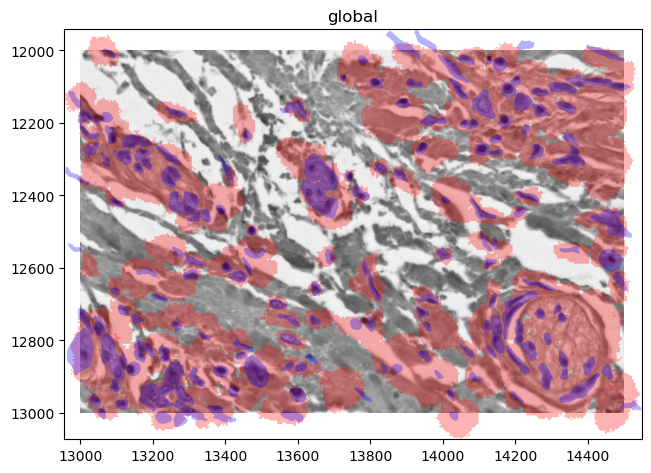

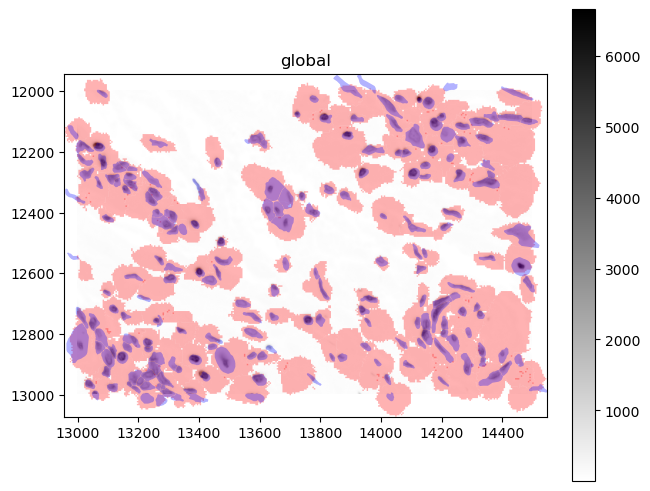

In [15]:
import spatialdata_plot  # registers the .pl accessor

# 1) Render the “HE” image in grayscale (no colorbar)

attempt_info = "proseg_boundaries"

sdata.pl.render_images(element="HE", cmap="gray" ).pl.render_shapes(attempt_info, color="red", fill_alpha=0.3).pl.render_shapes("cell_boundaries", color="blue", fill_alpha=0.3).pl.show(coordinate_systems="global")
sdata.pl.render_images(element="Xenium_Image", channel="DAPI", cmap="gray_r" ).pl.render_shapes(attempt_info, color="red", fill_alpha=0.3).pl.render_shapes("cell_boundaries", color="blue", fill_alpha=0.3).pl.show(coordinate_systems="global")

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
WARNING  One cmap was given for multiple channels and is now used for each channel. You're blending multiple cmaps.
         If the plot doesn't look like you expect, it might be because your cmaps go from a given color to 'white',
         and not to 'transparent'. Therefore, the 'white' of higher layers will overlay the lower layers. Consider 
         using 'palette' instead.                                                                                  
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


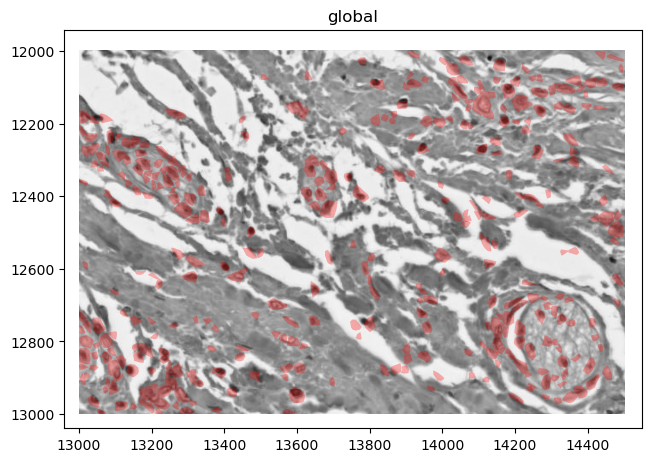

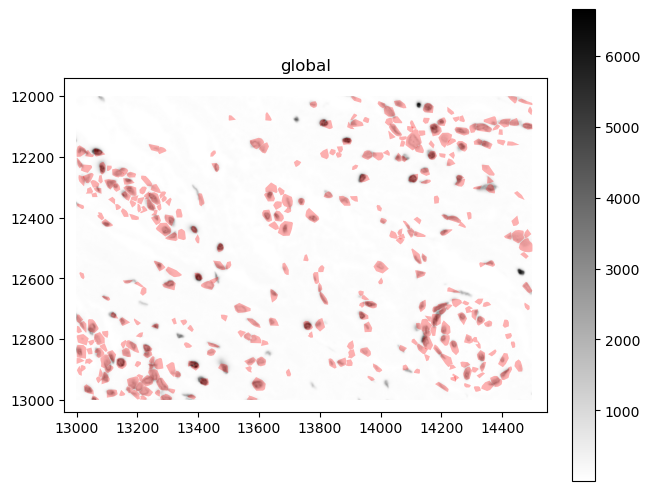

In [12]:
import spatialdata_plot  # registers the .pl accessor

# 1) Render the “HE” image in grayscale (no colorbar)


sdata.pl.render_images(element="HE", cmap="gray" ).pl.render_shapes(attempt_info, color="red", fill_alpha=0.30).pl.render_shapes("cell_boundaries", color="blue", fill_alpha=0).pl.show(coordinate_systems="global")
sdata.pl.render_images(element="Xenium_Image", channel="DAPI", cmap="gray_r" ).pl.render_shapes(attempt_info, color="red", fill_alpha=0.3).pl.render_shapes("cell_boundaries", color="blue", fill_alpha=0).pl.show(coordinate_systems="global")

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
WARNING  One cmap was given for multiple channels and is now used for each channel. You're blending multiple cmaps.
         If the plot doesn't look like you expect, it might be because your cmaps go from a given color to 'white',
         and not to 'transparent'. Therefore, the 'white' of higher layers will overlay the lower layers. Consider 
         using 'palette' instead.                                                                                  
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


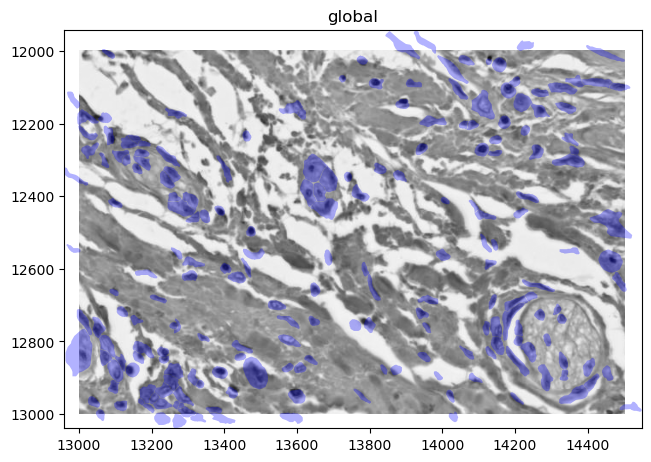

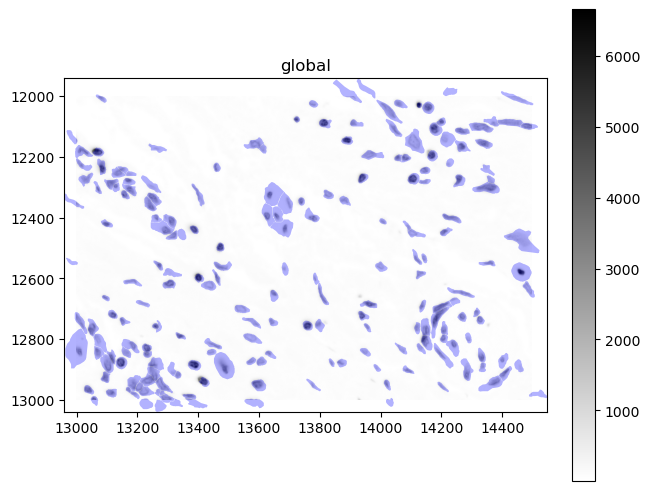

In [13]:
import spatialdata_plot  # registers the .pl accessor

# 1) Render the “HE” image in grayscale (no colorbar)


sdata.pl.render_images(element="HE", cmap="gray" ).pl.render_shapes(attempt_info, color="red", fill_alpha=0).pl.render_shapes("cell_boundaries", color="blue", fill_alpha=0.3).pl.show(coordinate_systems="global")
sdata.pl.render_images(element="Xenium_Image", channel="DAPI", cmap="gray_r" ).pl.render_shapes(attempt_info, color="red", fill_alpha=0).pl.render_shapes("cell_boundaries", color="blue", fill_alpha=0.3).pl.show(coordinate_systems="global")

In [14]:
import pandas as pd

# List of (name, DataFrame) pairs
dfs = [cellpose,baysor,
     stardist_versatileFluo,
     stardist_versatileHE]

combined = pd.concat(
    [df[["name", "DICE"]] for df in dfs],
    ignore_index=True
)

# 2) Sort by DICE descending and view the top rows
combined.sort_values("DICE", ascending=False).head(50)["name"].to_list()


NameError: name 'cellpose' is not defined